In [10]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from imblearn.combine import SMOTETomek  
import joblib
import pickle

In the features, 1 means "yes" and 0 means "no"

In [17]:
# ---------- 1. Model for ICU Prediction ----------

=== Training Metrics ===
F1 Score: 0.8961247765994762
Accuracy: 0.8965297300565279
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.83      0.89    165405
         1.0       0.85      0.96      0.90    165405

    accuracy                           0.90    330810
   macro avg       0.90      0.90      0.90    330810
weighted avg       0.90      0.90      0.90    330810


=== Test Metrics ===
F1 Score: 0.8342662760529949
Accuracy: 0.7899665401630325
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     41426
         1.0       0.17      0.51      0.25      3105

    accuracy                           0.79     44531
   macro avg       0.56      0.66      0.57     44531
weighted avg       0.90      0.79      0.83     44531



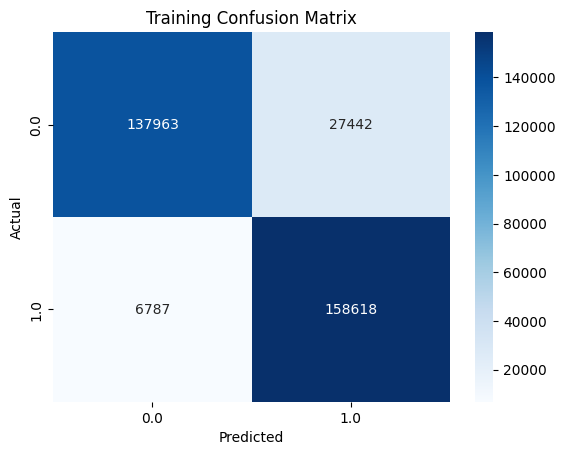

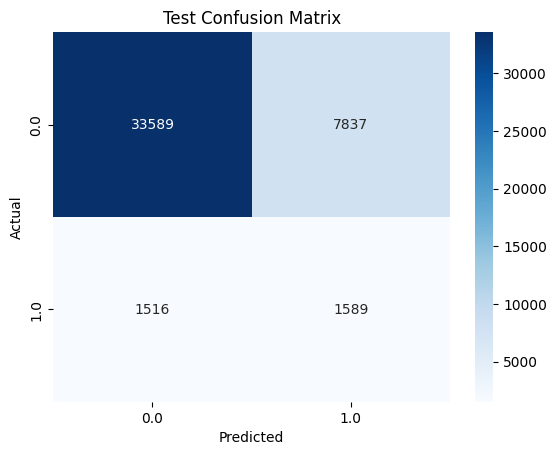

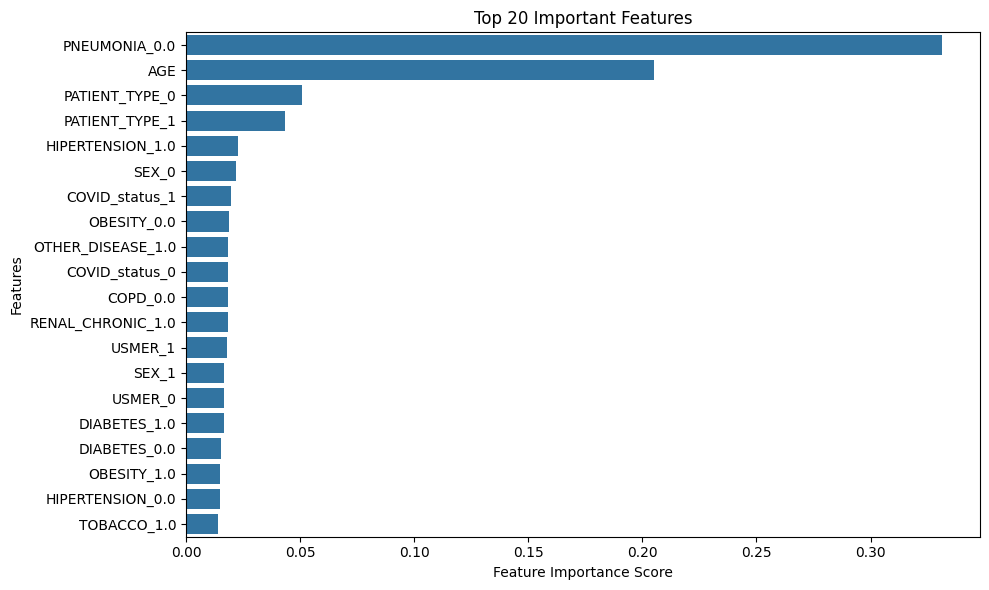

In [11]:
# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Drop INTUBED, ICU, and DIED
df = df.drop(columns=["INTUBED", "DIED"])
df = df.dropna(subset=["ICU"])
icu_target = df["ICU"]
df = df.drop(columns=["ICU"])
df = df.dropna()
icu_target = icu_target.loc[df.index]

# Step 3: Convert categorical columns to string
for col in df.columns:
    if col != "AGE":
        df[col] = df[col].astype(str)

# Step 4: Train/test split BEFORE encoding
X_train, X_test, y_train, y_test = train_test_split(df, icu_target, test_size=0.2, random_state=42)

# Step 5: One-hot encode after split
categorical_cols = [col for col in df.columns if col != 'AGE']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_cols])

# Save the encoder
with open('encoder_ICU.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Transform train and test
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Convert to DataFrames
encoded_cols = encoder.get_feature_names_out(categorical_cols)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Add back AGE
X_train_final = pd.concat([X_train[['AGE']], X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test[['AGE']], X_test_encoded_df], axis=1)

# Step 6: Apply SMOTETomek ONLY to training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_final, y_train)

# Step 7: Train Decision Tree classifier
clf = DecisionTreeClassifier(
    class_weight='balanced',    
    random_state=42
)
clf.fit(X_train_resampled, y_train_resampled)

# Step 8: Predictions and metrics
y_train_pred = clf.predict(X_train_resampled)
y_test_pred = clf.predict(X_test_final)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train_resampled, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("Classification Report:\n", classification_report(y_train_resampled, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Step 9: Plot confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train_resampled, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test, y_test_pred, "Test Confusion Matrix")

# Step 10: Feature Importance
importances = pd.Series(clf.feature_importances_, index=X_train_resampled.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [12]:
# === Save previously trained model and feature list ===
joblib.dump(clf, "icu_model.pkl")
joblib.dump(X_train_resampled.columns.tolist(), "icu_features.pkl")

['icu_features.pkl']

In [14]:
# === Load model, scaler, and feature names ===
loaded_clf = joblib.load("icu_model.pkl")
model_features = joblib.load("icu_features.pkl")

In [15]:
loaded_clf

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [16]:
model_features

['AGE',
 'USMER_0',
 'USMER_1',
 'SEX_0',
 'SEX_1',
 'PATIENT_TYPE_0',
 'PATIENT_TYPE_1',
 'PNEUMONIA_0.0',
 'PNEUMONIA_1.0',
 'DIABETES_0.0',
 'DIABETES_1.0',
 'COPD_0.0',
 'COPD_1.0',
 'ASTHMA_0.0',
 'ASTHMA_1.0',
 'INMSUPR_0.0',
 'INMSUPR_1.0',
 'HIPERTENSION_0.0',
 'HIPERTENSION_1.0',
 'OTHER_DISEASE_0.0',
 'OTHER_DISEASE_1.0',
 'CARDIOVASCULAR_0.0',
 'CARDIOVASCULAR_1.0',
 'OBESITY_0.0',
 'OBESITY_1.0',
 'RENAL_CHRONIC_0.0',
 'RENAL_CHRONIC_1.0',
 'TOBACCO_0.0',
 'TOBACCO_1.0',
 'COVID_status_0',
 'COVID_status_1']

In [ ]:
# ---------- 2. Model for PATIENT_TYPE Prediction ----------

=== Training Metrics ===
F1 Score: 0.8176891142037501
Accuracy: 0.8176997817226526
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82    103538
           1       0.82      0.81      0.82    103538

    accuracy                           0.82    207076
   macro avg       0.82      0.82      0.82    207076
weighted avg       0.82      0.82      0.82    207076


=== Test Metrics ===
F1 Score: 0.7084823008772368
Accuracy: 0.7081583615908019
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.75     25968
           1       0.65      0.66      0.65     18563

    accuracy                           0.71     44531
   macro avg       0.70      0.70      0.70     44531
weighted avg       0.71      0.71      0.71     44531



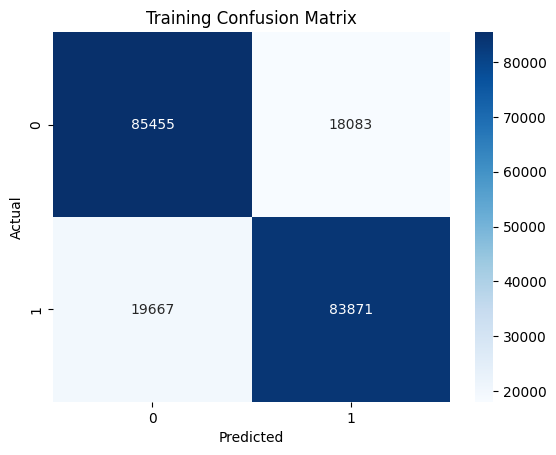

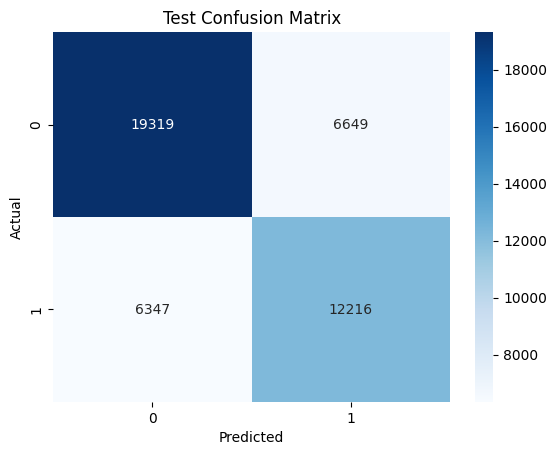

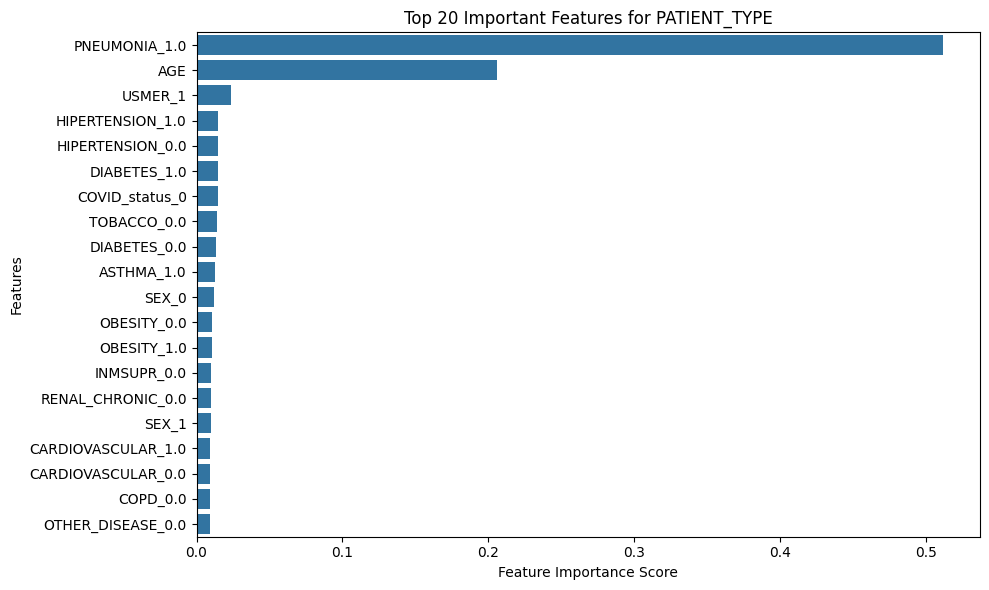

In [13]:
# Step 1: Load and clean initial data
df = pd.read_csv("imputed_covid_data_m2_modified.csv")
df = df.replace("nan", np.nan)

# Step 2: Drop unwanted columns (INTUBED, ICU, DIED) and handle missing PATIENT_TYPE
df = df.drop(columns=["INTUBED", "ICU", "DIED"])
df = df.dropna(subset=["PATIENT_TYPE"])
patient_type_target = df["PATIENT_TYPE"]
df = df.drop(columns=["PATIENT_TYPE"])
df = df.dropna()  # Drop rows with missing values
patient_type_target = patient_type_target.loc[df.index]  # Align target with cleaned df

# Step 3: Convert categorical columns to string
for col in df.columns:
    if col != "AGE":
        df[col] = df[col].astype(str)

# Step 4: Train/test split BEFORE encoding
X_train, X_test, y_train, y_test = train_test_split(df, patient_type_target, test_size=0.2, random_state=42)

# Step 5: One-hot encoding with OneHotEncoder
categorical_cols = [col for col in df.columns if col != "AGE"]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_cols])

# Save encoder for Flask use
with open('encoder_patient_type.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Transform training and test data
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

encoded_cols = encoder.get_feature_names_out(categorical_cols)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Add AGE back to encoded data
X_train_final = pd.concat([X_train[['AGE']], X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test[['AGE']], X_test_encoded_df], axis=1)

# Step 6: SMOTETomek only on training data (using SMOTETomek instead of SMOTE)
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_final, y_train)

# Step 7: Train the model
clf = DecisionTreeClassifier(
    class_weight='balanced',    
    random_state=42
)
clf.fit(X_train_smotetomek, y_train_smotetomek)

# Step 8: Predictions
y_train_pred = clf.predict(X_train_smotetomek)
y_test_pred = clf.predict(X_test_final)

print("=== Training Metrics ===")
print("F1 Score:", f1_score(y_train_smotetomek, y_train_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_train_smotetomek, y_train_pred))
print("Classification Report:\n", classification_report(y_train_smotetomek, y_train_pred))

print("\n=== Test Metrics ===")
print("F1 Score:", f1_score(y_test, y_test_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Step 9: Confusion matrices
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train_smotetomek, y_train_pred, "Training Confusion Matrix")
plot_conf_matrix(y_test, y_test_pred, "Test Confusion Matrix")

# Step 10: Feature importance
importances = pd.Series(clf.feature_importances_, index=X_train_smotetomek.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features, y=top_features.index)
plt.title('Top 20 Important Features for PATIENT_TYPE')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [17]:
# === Save the trained PATIENT_TYPE model, scaler, and feature list ===
joblib.dump(clf, "patient_type_model.pkl")
joblib.dump(X_train_smotetomek.columns.tolist(), "patient_type_features.pkl")

['patient_type_features.pkl']

In [21]:
# === Load the PATIENT_TYPE model, scaler, and feature names ===
loaded_clf = joblib.load("patient_type_model.pkl")
model_features = joblib.load("patient_type_features.pkl")